# Utilizing computational patterns

From https://toolz.readthedocs.io/en/latest/control.html

Often when writing code we repeat certain patterns, whether we realize it or not.
If you have learned to write list comprehensions, you are taking advantage of a "control pattern".
Often, these patterns are so common that many packages have built in functions to implement them.

> The Toolz library contains dozens of patterns like map and groupby. Learning a
> core set (maybe a dozen) covers the vast majority of common programming tasks
> often done by hand. A rich vocabulary of core control functions conveys the
> following benefits:
>
> - You identify new patterns
> - You make fewer errors in rote coding
> - You can depend on well tested and benchmarked implementations

The same is true for xarray

## Motivation / Learning goals

- Learn what high-level computational patterns are available in Xarray
- Identify when you are using a high-level computational pattern
- Implement that pattern using built-in Xarray functionality

## Xarray's high-level patterns

Xarray allows you to leverage dataset metadata to write more readable analysis
code. The metadata is stored with the data; not in your head.

1. Dimension names: `dim="latitude"` instead of `axis=0`
2. Coordinate "labels": or axis tick labels. `data.sel(latitude=45)` instead of
   `data[10]`

Xarray also provides high-level computational patterns that cover many data
analysis tasks.

1. `rolling` :
   [Operate on rolling windows of your data e.g. running mean](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations)
1. `coarsen` :
   [Downsample your data](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays)
1. `groupby` :
   [Bin data in to groups and reduce](https://docs.xarray.dev/en/stable/groupby.html)
1. `groupby_bins`: GroupBy after discretizing a numeric variable.
1. `resample` :
   [GroupBy specialized for time axes. Either downsample or upsample your data.](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)


Note: the documentation links in this tutorial point to the DataArray implementations of each function, but they are also available for DataSet objects.


### Load example dataset


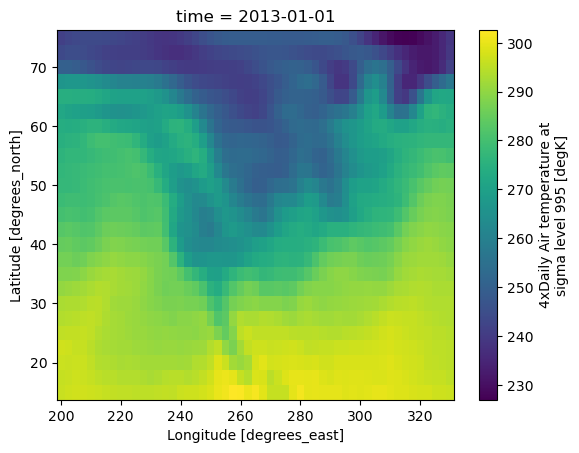

In [1]:
import numpy as np
import xarray as xr

xr.set_options(keep_attrs=True, display_expand_data=False)

da = xr.tutorial.load_dataset("air_temperature", engine="netcdf4").air
monthly = da.resample(time="M").mean()
data = da.isel(time=0)
data.plot()

---

### Identifying high-level computation patterns

*or, when should I use these functions?*

Consider a common use case. We want to complete some "task" for each of "something". The "task" might be a computation (e.g. mean, median, plot). The "something" could be a group of array values (e.g. pixels) or segments of time (e.g. monthly or seasonally).

Often, our solution to this type of problem is to write a loop. Say we want the average air temperature for each month:

In [37]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]
avg_temps = []

for mon in months:
    avg = da[da["time.month"]==mon].mean()
    avg_temps.append(float(avg.data))

print(avg_temps)

[273.416748046875, 273.13104248046875, 275.1137390136719, 278.5469970703125, 283.299072265625, 287.5657043457031, 289.90692138671875, 290.089111328125, 287.41375732421875, 283.6811828613281, 277.9678039550781, 274.35107421875]


Writing a for-loop here is not wrong, but it can quickly become cumbersome if you have a complex function to apply and it will take awhile to compute on a large dataset (you may even run out of memory). Parallelizing the computation would take a lot of additional work.

Xarray's functionality instead allows us to do the same computation in one line of code (plus, the computation is optimized and ready to take advantage of parallel compute resources)!

In [54]:
for label, group in da.groupby("time.month"):
    print(group.mean().data)
    
avg_temps = da.groupby("time.month").mean()
print(avg_temps.data)

273.41675
273.13104
275.11374
278.547
283.29907
287.5657
289.90692
290.0891
287.41376
283.68118
277.9678
274.35107
[[[246.34987 246.38608 246.21518 ... 243.06113 244.08795 245.6467 ]
  [248.8576  248.90733 248.7104  ... 241.52866 243.50865 246.75471]
  [251.57712 251.19661 250.71463 ... 243.39891 246.78462 251.56572]
  ...
  [295.85028 295.24405 295.22684 ... 295.18625 294.65707 294.0485 ]
  [296.5446  296.46982 296.15994 ... 295.35593 295.0812  294.53006]
  [297.15417 297.2383  297.04892 ... 296.01797 295.77554 295.63647]]

 [[246.67715 246.40576 245.9484  ... 241.85838 243.0021  244.44383]
  [247.8001  247.75992 247.47757 ... 240.64706 242.26633 245.06662]
  [249.07079 248.57234 247.94254 ... 242.42874 245.33348 249.72273]
  ...
  [295.92886 295.41788 295.16602 ... 294.4443  293.78143 293.18265]
  [296.78754 296.63443 296.15707 ... 294.51166 294.2178  293.70258]
  [297.2889  297.2165  296.85797 ... 295.16058 294.9558  294.87967]]

 [[251.03168 250.67987 250.18945 ... 242.19398 243.11

In [49]:
da.groupby("time.month").mean()

<xarray.DataArray 'air' (month: 12, lat: 25, lon: 53)>
246.3 246.4 246.2 245.8 245.2 244.6 ... 298.1 298.0 298.0 297.6 297.6 297.5
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

Read on through this tutorial to learn some of the incredible ways to use Xarray to avoid writing long for-loops and efficiently complete computational analyses on your data.

---

### Concept refresher: "index space" vs "label space"


In [ ]:
data

In [ ]:
# index space
data[10, :]  # 10th element along the first axis; ¯\_(ツ)_/¯

In [ ]:
# slightly better index space
data.isel(lat=10)  # slightly better, 10th element in latitude

In [ ]:
# "label" space
data.sel(lat=50)  # much better! lat=50°N

In [ ]:
# What I wanted to do
data.sel(lat=50)

# What I had to do (if I wasn't using xarray)
data[10, :]

---

## Xarray provides high-level patterns in both "index space" and "label space"

### Index space

These are windowed operations with a window of a fixed size.

1. `rolling` :
   [Operate on rolling (sliding) windows of your data e.g. running mean](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations)
1. `coarsen` :
   [Downsample your data (decimating, reshaping)](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays)

### Label space

These are windowed operations with irregular windows based on your data.

1. `groupby` :
   [Bin data in to groups and reduce](https://docs.xarray.dev/en/stable/groupby.html)
1. `groupby_bins`: GroupBy after discretizing a numeric variable.
1. `resample` :
   [Groupby specialized for time axes. Either downsample or upsample your data.](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)


add some "loop" versions to show what a user might come up with that could be turned into one of these pattern operations

---

## Index space: windows of fixed width

### Sliding windows of fixed length: [`rolling`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.rolling.html)

- returns object of same shape as input
- pads with NaNs to make this happen
- supports multiple dimensions

Here's the dataset


In [ ]:
data.plot()

And now smoothed 5 point running mean in lat and lon


In [ ]:
data.rolling(lat=5, lon=5, center=True).mean().plot()

#### Apply an existing numpy-only function with `reduce`

In some cases, we may want to apply a sliding window function using rolling that is not built in to Xarray. In these cases we can still leverage the sliding windows of rolling and apply our own function with [`reduce`](https://docs.xarray.dev/en/stable/generated/xarray.core.rolling.DataArrayRolling.reduce.html).

Tip: The `reduce` method expects a function that can receive and return plain arrays (e.g. numpy), as in each of the "windows" provided by the rolling iterator. This is in contrast to the `map` method, which expects a function that can receive and return Xarray objects.

Here's an example function: [`np.ptp`](https://numpy.org/doc/stable/reference/generated/numpy.ptp.html).


In [ ]:
data.rolling(lat=5, lon=5, center=True).reduce(np.ptp).plot()

**Exercise** Calculate the rolling mean in 5 point bins along both latitude and longitude using
[`rolling(**kwargs).reduce`](https://docs.xarray.dev/en/stable/generated/xarray.core.rolling.DataArrayRolling.reduce.html)


**Answer**


In [ ]:
# exactly equivalent to data.rolling(...).mean()
data.rolling(lat=5, lon=5, center=True).reduce(np.mean).plot()

#### Storing the outputs from `rolling` operations with `construct`

In the above examples, we plotted the outputs of our rolling operations. Xarray makes it easy to store the outputs from `rolling` directly into the DataArray using the [`construct`](https://docs.xarray.dev/en/stable/generated/xarray.core.rolling.DataArrayRolling.construct.html#xarray.core.rolling.DataArrayRolling.construct) method.

In [ ]:
simple = xr.DataArray(np.arange(10), dims="time", coords={"time": np.arange(10)})
simple

In [ ]:
# adds a new dimension "window"
simple.rolling(time=5, center=True).construct("window")

**Exercise** Calculate the 5 point running mean in time and add it to your DataArray using `rolling.construct`

**Answer**


In [ ]:
(simple.rolling(time=5, center=True).construct("window").mean("window"))

`construct` is clever.

1. It constructs a **view** of the original array, so it is memory-efficient.
   but you didn't have to know that.
1. It does something sensible for dask arrays (though generally you want big
   chunksizes for the dimension you're sliding along).
1. It also works with rolling along multiple dimensions!


#### Advanced: Another `construct` example

This is a 2D rolling example; we need to provide two new dimension names.


In [ ]:
data.rolling(lat=5, lon=5, center=True).construct(lat="lat_roll", lon="lon_roll")

---

### Block windows of fixed length: `coarsen`

For non-overlapping windows or "blocks" use [`coarsen`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.coarsen.html). The syntax is very similar to `rolling`. You will need to specify how you want Xarray to handle the `boundary` if the length of the dimension is not a multiple of the block size.


In [ ]:
data

In [ ]:
data.plot()

In [ ]:
data.coarsen(lat=5, lon=5, boundary="trim").mean()

In [ ]:
(data.coarsen(lat=5, lon=5, boundary="trim").mean().plot())

#### Coarsen supports `reduce` for custom reductions

**Exercise** Use `coarsen.reduce` to apply `np.ptp` in 5x5 (lat x lon) point blocks to `data`

**Answer**


In [ ]:
(data.coarsen(lat=5, lon=5, boundary="trim").reduce(np.mean).plot())

#### Coarsen supports `construct` for block reshaping and storing outputs

This is usually a good alternative to `np.reshape`

A simple example splits a 2-year long monthly 1D time series into a 2D array shaped (year x month)


In [ ]:
months = xr.DataArray(
    np.tile(np.arange(1, 13), reps=2),
    dims="time",
    coords={"time": np.arange(1, 25)},
)
months

In [ ]:
# break "time" into two new dimensions: "year", "month"
months.coarsen(time=12).construct(time=("year", "month"))

Note two things:

1. The `time` dimension was also reshaped.
1. The new dimensions `year` and `month` don't have any coordinate labels
   associated with them.

What if the data had say 23 instead of 24 values (`months.isel(time=slice(1, None)`)? In that case we specify a different `boundary` (the default `boundary="exact"` worked above); here we pad to 24 values.


In [ ]:
months.isel(time=slice(1, None)).coarsen(time=12, boundary="pad").construct(time=("year", "month"))

This adds values at the end of the array (see the 'nan' at the end of the time coordinate?), which is not so sensible for this
problem.  We have some control of the padding through the `side` kwarg to `coarsen`. For `side="right"` we get more sensible output.

In [ ]:
months.isel(time=slice(1, None)).coarsen(time=12, boundary="pad", side="right").construct(
    time=("year", "month")
)

Note that `coarsen` pads with NaNs. For more control over padding, use
[DataArray.pad](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.pad.html) explicitly.

In [ ]:
(
    months.isel(time=slice(1, None))
    .pad(time=(1, 0), constant_values=-1)
    .coarsen(time=12)
    .construct(time=("year", "month"))
)

# NOTE: check output of this cell (why is the first value of time nan instead of -1?)

**Exercise** Reshape the `time` dimension of the DataArray `monthly` to year x
month and visualize the seasonal cycle for two years at 250°E


**Answer**


In [ ]:
# splits time dimension into year x month
year_month = monthly.coarsen(time=12).construct(time=("year", "month"))

# assign a nice coordinate value for month
year_month["month"] = [
    "jan",
    "feb",
    "mar",
    "apr",
    "may",
    "jun",
    "jul",
    "aug",
    "sep",
    "oct",
    "nov",
    "dec",
]

# assign a nice coordinate value for year
year_month["year"] = [2013, 2014]

# seasonal cycle for two years
year_month.sel(lon=250).plot.contourf(col="year", x="month", y="lat")

This exercise came up during a live lecture.

**Exercise** Calculate the rolling 4 month average, averaged across years.

**Answer**

1. We first reshape using `coarsen.construct` to add `year` as a new dimension.
2. Apply `rolling` on the month dimension.
3. It turns out that `roll.mean(["year", "month"])` doesn't work. So we use `roll.construct` to get a DataArray with a new dimension `window` and then take the mean over `window` and `year`


In [ ]:
reshaped = months.coarsen(time=12).construct(time=("year", "month"))
roll = reshaped.rolling(month=4, center=True)
roll.construct("window").mean(["window", "year"])

### Index space summary

Use `rolling` and `coarsen` for fixed size windowing operations.

1. `rolling` for overlapping windows
1. `coarsen` for non-overlapping windows.

Both provide the usual reductions as methods (`.mean()` and friends), and also
`reduce` and `construct` for custom operations.


---

## Label space "windows" or bins : GroupBy

Sometimes the windows you want are not regularly spaced or even defined by a grid.
For instance, grouping data by month (which have varying numbers of days) or the results of an image classification.
The GroupBy functions are essentially a generalization of `coarsen`: 

- `groupby`: divide data into distinct groups, e.g. climatologies, composites. Works when "groups" are exact and can be determined using equality (`==`), e.g. characters or integers. Remember that floats are not exact values.
- `groupby_bins`: Use binning operations, e.g. histograms, to group your data.
- `resample`: Specialized implementation of GroupBy specifically for time grouping (so far)

**hint** Both `groupby_bins` and `resample` are implemented as `GroupBy` with a specific way of constructing group labels.

### Deconstructing GroupBy

The GroupBy workflow is commonly called "split-apply-combine".

1. "split" : break dataset into groups
1. "apply" : apply an operation, for instance a reduction like `mean`
1. "combine" : concatenate results from apply step along a new "group" dimension

But really there is a "hidden" first step: identifying groups (also called factorization or binning). Usually this is the hard part.

In reality the workflow is: "identify groups" → "split into groups" → "apply function" → "combine results".


In [ ]:
# recall our earlier DataArray
da

In [ ]:
# GroupBy returns an iterator that traverses the specified groups, here by month.
# Notice that groupby is clever enough for us to leave out the `.dt` before `.month`
# we would need to specify to access the month data directly (see plot below).
da.groupby("time.month")

In [ ]:
# for each group (e.g. the air temperature in a given month for all the years),
# compute the mean
da.groupby("time.month").mean()

Notice that since we have averaged over all the years for each month, our resulting DataArray no longer has a "year" coordinate.

If we want to see how Xarray identifies "groups" for the monthly climatology computation, we can plot our input to `groupby`. GroupBy is clever enough to figure out how many values there are an thus how many groups to make.


In [ ]:
da.time.month.plot()

Similarly for binning (remember this is useful when the parameter you are binning over is not "exact", like a float),


In [ ]:
data.groupby_bins("lat", bins=[20, 35, 40, 45, 50])

and resampling...


In [ ]:
da.resample(time="M")

QUSTION (intentionally spelled wrong so a check will catch this block) - I want to explain why resample with time="M" has 24 bins, while groupby over month had 12. But I don't actually know...

### Constructing group labels

Xarray uses [`pandas.factorize`](https://pandas.pydata.org/docs/reference/api/pandas.factorize.html) for `groupby` and [`pandas.cut`](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) for `groupby_bins`.

#### Functions to construct group labels
If the automatic group detection doesn't work for your problem then these functions are useful for constructing specific "group labels" in many cases

1. [numpy.digitize](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html)
   for binning
1. [numpy.searchsorted](https://numpy.org/doc/stable/reference/generated/numpy.searchsorted.html)
   supports many other data types
1. [pandas.factorize](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html)
   supports characters, strings etc.
1. [pandas.cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html)
   for binning
1. [DataArray.isin](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.isin.html)


#### ["Datetime components"](https://docs.xarray.dev/en/stable/user-guide/time-series.html#datetime-components) for creating groups

See a full list
[here](https://docs.xarray.dev/en/stable/generated/xarray.core.accessor_dt.DatetimeAccessor.html?highlight=DatetimeAccessor)

These can be accessed in a few different ways as illustrated below.


In [ ]:
da.time

In [ ]:
da.time.dt.day

In [ ]:
da["time.day"]

In [ ]:
da.time.dt.season

#### Construct and use custom labels

**Demo** Grouping over a custom definition of seasons using numpy.isin.

We want to group over four seasons: `DJF`, `MAM`, `JJAS`, `ON` - this makes physical sense in the Indian Ocean basin.

Start by extracting months.


In [ ]:
month = da.time.dt.month.data
month

Create a new empty array


In [ ]:
myseason = np.full(month.shape, "    ")
myseason

Use `isin` to assign custom seasons,


In [ ]:
myseason[np.isin(month, [12, 1, 2])] = "DJF"
myseason[np.isin(month, [3, 4, 5])] = "MAM"
myseason[np.isin(month, [6, 7, 8, 9])] = "JJAS"
myseason[np.isin(month, [10, 11])] = "ON"

Turn our new seasonal group array into a DataArray.

In [ ]:
myseason_da = da.time.copy(data=myseason)
myseason_da

In [ ]:
# Why don't we add the season array to the original dataarray (da) and
# use da.groupby("myseason")? To me, it's confusing to now need two dataarrays

(
    # Calculate climatology
    da.groupby(myseason_da)
    .mean()
    # reindex to get seasons in logical order (not alphabetical order)
    .reindex(time=["DJF", "MAM", "JJAS", "ON"])
    .plot(col="time")
)

Equivalently, we could add our custom seasons to our original DataArray and use groupby there.

In [ ]:
da = da.assign({"myseason" : (("time"), myseason)})
(
    # Calculate climatology
    da.groupby("myseason")
    .mean()
    # reindex to get seasons in logical order (not alphabetical order)
    .reindex(time=["DJF", "MAM", "JJAS", "ON"])
    .plot(col="time")
)

##### `floor`, `ceil` and `round` on time

Additional functionality in the [datetime accessor](https://docs.xarray.dev/en/stable/generated/xarray.core.accessor_dt.DatetimeAccessor.html) allows us to effectively "resample" our time data to remove roundoff errors in timestamps.


In [ ]:
da.time

In [ ]:
# remove roundoff error in timestamps
# floor to daily frequency
da.time.dt.floor("D")

##### `strftime` is another powerful option

So useful and so unintuitive that it has its own website: https://strftime.org/

This is useful to avoid merging "Feb-29" and "Mar-01" for a daily climatology


In [ ]:
da.time.dt.strftime("%b-%d")

### Custom reductions with GroupBy

Analagous to `rolling`, `reduce` and `map` apply custom reductions to `groupby_bins` and `resample`.


In [ ]:
(da.groupby("time.month").reduce(np.ptp).plot(col="month", col_wrap=4))

**tip** `map` is for functions that expect and return xarray objects (see also [`Dataset.map`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.map.html)). `reduce` is for functions that expect and return plain arrays (like Numpy or SciPy functions).


### Adding GroupBy outputs to your DataArray or DataSet

GroupBy does not provide a `construct` method, because all the groups need not be the same "length" (e.g. months can have 28, 29, 30, or 31 days).

#### Instead looping over groupby objects is possible

Because `groupby` returns an iterator that loops over each group, it is easy to loop over groupby objects.

Maybe you want to plot data in each group separately:


In [ ]:
for label, group in da.groupby("time.month"):
    print(label)

This is a DataArray containing data for all December days (because the last printed `label` value is `12`, so the last `group` value is for December).

In [ ]:
group

Maybe you want a histogram of December temperatures?


In [ ]:
group.plot.hist()

Remember, this is example is just to show how you could operate on each group object in a groupby operation. If we wanted to just explore the December (or March) data, we should just filter for it directly:

In [ ]:
da[["time.month"==12]].plot.hist()

#### In most cases, avoid a for loop using `map`

`map` enables us to apply functions that expect xarray Datasets or DataArrays. This makes it easy to perform calculations on the grouped data, add the results from each group back to the original object, and avoid having to manually combine results (using concat).


In [ ]:
def iqr(gb_da, dim):
    """Calculates interquartile range"""
    return (gb_da.quantile(q=0.75, dim=dim) - gb_da.quantile(q=0.25, dim=dim)).rename("iqr")


da.groupby("time.month").map(iqr, dim="time")

---


## Summary

Xarray provides methods for high-level analysis patterns:

1. `rolling` :
   [Operate on rolling (fixed length, overlapping) windows of your data e.g. running mean](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations)
1. `coarsen` :
   [Operate on blocks (fixed length) of your data (downsample)](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays)
1. `groupby` :
   [Parse data into groups (using an exact value) and operate on each one (reduce data)](https://docs.xarray.dev/en/stable/groupby.html)
1. `groupby_bins`: [GroupBy after discretizing a numeric (non-exact, e.g. float) variable](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby_bins.html)
1. `resample` :
   [Groupby specialized for time axes. Either downsample or upsample your data.](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)


## More resources

1. [Weight your data before reducing](https://docs.xarray.dev/en/stable/user-guide/computation.html#weighted-array-reductions)
1. More tutorials here: https://tutorial.xarray.dev/
1. Answers to common questions on "how to do X" are here:
   https://docs.xarray.dev/en/stable/howdoi.html
